# Topic Modelling

In [ ]:
pip install -r requirement.txt

In [1]:
from lda_gensim_modularized import *

In [1]:
from platform import python_version
print(python_version())

3.10.4


In [2]:
# Read in cleaned reviews
df_path = '../data/curated/reviews/cleaned_reviews.csv'
clean_data = read_data(df_path)

In [3]:
# obtain tfidf corpus
data = combine_reviews_to_list(clean_data)
data_words, id2word, bow_corpus = obtain_corpus(data)
corpus_tfidf = get_tfidf_corpus(bow_corpus)

In [4]:
# run LDA baseline model
lda_base_model = load_base_lda_model(data_words, id2word, corpus_tfidf)

Baseline Coherence Score:  0.3741965329013099


Num Topics = 2  has Coherence Value of 0.3775
Num Topics = 3  has Coherence Value of 0.6298
Num Topics = 4  has Coherence Value of 0.535
Num Topics = 5  has Coherence Value of 0.5213
Num Topics = 6  has Coherence Value of 0.5733
Num Topics = 7  has Coherence Value of 0.5392
Num Topics = 8  has Coherence Value of 0.5707
Num Topics = 9  has Coherence Value of 0.5508


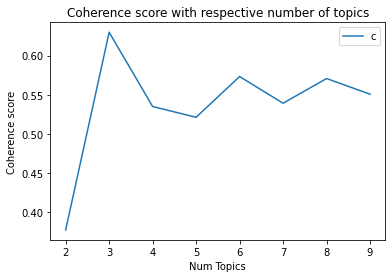

In [5]:
# Obtain optimal number of topics
final_num_topics, final_score, coherence_score_topic = get_coherence_values_and_optimal_topic_num(corpus_tfidf,10, id2word, data_words)

In [44]:
# run final LDA model using optimal number of topics
lda_final_model = load_final_lda_model(id2word, corpus_tfidf, final_num_topics)

# print 10 keywords of the topics
unique_sets(lda_final_model)

Topic: 0 
Words: 0.006*"coffee" + 0.004*"tea" + 0.004*"cup" + 0.003*"love" + 0.003*"price" + 0.003*"buy" + 0.003*"much" + 0.003*"chocolate" + 0.003*"try" + 0.003*"really"
Topic: 1 
Words: 0.003*"snack" + 0.003*"love" + 0.003*"bar" + 0.003*"price" + 0.003*"chip" + 0.003*"buy" + 0.003*"find" + 0.003*"try" + 0.003*"eat" + 0.003*"would"
Topic: 2 
Words: 0.004*"tea" + 0.004*"dog" + 0.003*"treat" + 0.003*"food" + 0.002*"love" + 0.002*"buy" + 0.002*"coffee" + 0.002*"cat" + 0.002*"eat" + 0.002*"china"
Topic 0: {'cup', 'much', 'chocolate', 'really'}
Topic 1: {'snack', 'would', 'bar', 'find', 'chip'}
Topic 2: {'treat', 'dog', 'china', 'cat', 'food'}


In [8]:
# Obtain the dominant topic for each review and save it to csv
topic_df, df = save_dominant_topic_per_review(lda_final_model, corpus_tfidf, data)
# topic distribution 
topic_distri_across_review(topic_df)

C:\Users\User\dsa4263-pietonium\topic_modelling\lda_gensim_modularized.py:220: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\User\dsa4263-pietonium\topic_modelling\lda_gensim_modularized.py:220: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


0    2455
1    2226
2     763
Name: Dominant_Topic, dtype: int64

# Topic Classification

In [54]:
from topic_classification_modularized import *

In [55]:
train, test = split_test_train(df)

In [56]:
# Obtain train and test corpus respectively using LDA dictionary aka id2words 
x_train_corpus = preprocess_test_train(train, id2word)
x_test_corpus = preprocess_test_train(test, id2word)

In [57]:
y_train, y_test = y_label(train, test)

In [58]:
# Convert corpus to vectors to feed into sklearn
train_vecs = create_vectors(x_train_corpus, train, lda_final_model, final_num_topics)
test_vecs = create_vectors(x_train_corpus, test, lda_final_model, final_num_topics)

In [59]:
# Convert vector to scaled numpy array
x_train_scale, y_train, x_test_scale, y_test = convert_vector_to_scaled_array(train_vecs, y_train, test_vecs, y_test)

In [60]:
# Baseline_xgb
xgb_base = baseline_xgb(x_train_scale, y_train)

# Confusion matrix and classification report of baseline xgb
classification_df, confusion_matrix_df = predict_and_evaluate_model(xgb_base, x_test_scale, y_test)
print(classification_df, confusion_matrix_df)

              precision    recall  f1-score      support
0              0.425243  0.452479  0.438438   484.000000
1              0.367442  0.355856  0.361556   444.000000
2              0.111111  0.099379  0.104918   161.000000
accuracy       0.360882  0.360882  0.360882     0.360882
macro avg      0.301265  0.302571  0.301638  1089.000000
weighted avg   0.355235  0.360882  0.357784  1089.000000      0    1   2
0  219  206  59
1  217  158  69
2   79   66  16


In [61]:
tune_hyperparameter(x_train_scale, y_train)

Best: -0.055919 using {'n_estimators': 50}


In [62]:
# Final xgb
xgb_final = final_xgb(x_train_scale, y_train)

# Confusion matrix and classification report of baseline xgb
classification_df, confusion_matrix_df = predict_and_evaluate_model(xgb_final, x_test_scale, y_test)
print(classification_df, confusion_matrix_df)

              precision    recall  f1-score      support
0              0.425243  0.452479  0.438438   484.000000
1              0.366589  0.355856  0.361143   444.000000
2              0.111888  0.099379  0.105263   161.000000
accuracy       0.360882  0.360882  0.360882     0.360882
macro avg      0.301240  0.302571  0.301615  1089.000000
weighted avg   0.355002  0.360882  0.357667  1089.000000      0    1   2
0  219  207  58
1  217  158  69
2   79   66  16
